In [1]:
import numpy as np
from vowpalwabbit import pyvw
from newsenv import rand_simple_news_3
import random
import matplotlib.pyplot as plt

In [2]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={}\n".format(context["user"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [3]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)    
    pmf = vw.predict(vw_text_example)   
    chosen_action_index, prob = sample_custom_pmf(pmf)    
    return chosen_action_index,actions[chosen_action_index], prob

In [4]:
def run_simulation(vw,env,actions,num_iterations,epsilon,do_learn = True):
    cost_sum = 0.
    o_cost_sum=0
    ctr = []
    o_ctr=[]
    test_data=[]
    for i in range(1, num_iterations+1):
        context=env.get_context()        
        action_i,action, prob = get_action(vw, context, actions)        
        cost = env.get_cost(context, action_i)
        cost_sum += cost
        if do_learn:            
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)            
            vw.learn(vw_format)
            vw.finish_example(vw_format)
#         ctr.append(-1*cost_sum/i)
        ctr.append(-1*cost)
        o_action=env.get_e_optimal_action(context,epsilon) #Obtaining reward accoeding to e-optimal action
        o_cost=env.get_cost(context,o_action)
        o_cost_sum+=o_cost
#         o_ctr.append(-1*o_cost_sum/i)
        o_ctr.append(-1*o_cost)
    return ctr,cost_sum,o_ctr,o_cost_sum

In [5]:
def plot_ctr(avg_ctr,avg_o_ctr,maxP,minP):
    mean_ctr=np.mean(avg_ctr,axis=0)
    std_ctr=np.std(avg_ctr,axis=0)
    mean_o_ctr=np.mean(avg_o_ctr,axis=0)
    std_o_ctr=np.std(avg_o_ctr,axis=0)
    x=range(1,len(mean_ctr)+1)
    eve=int(len(x)/10)
    plt_lim=0.2
    plt.plot(x,mean_ctr,'--b',label='Learnt', alpha=0.6)
    plt.fill_between(x, mean_ctr-std_ctr,mean_ctr+std_ctr, alpha=0.4)
    plt.fill_between(x, mean_o_ctr-std_o_ctr,mean_o_ctr+std_o_ctr,'r',alpha=0.4)
#     plt.errorbar(x,mean_ctr,yerr=std_ctr,errorevery=eve,label='Learnt',fmt='--b')
#     plt.errorbar(x,mean_o_ctr,yerr=std_o_ctr,errorevery=eve,label='Optimal',fmt='--r')
    plt.plot(x,mean_o_ctr,'--r',label='Optimal', alpha=0.6)
    plt.xlabel('Events', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([minP*(1-plt_lim),maxP*(1+plt_lim)])
    plt.legend()
    plt.grid()
    plt.savefig('VWRSN3.pdf')
    plt.savefig('VWRSN3.jpg')
    plt.savefig('VWRSN3.png')

In [6]:
def get_avg(array,N=100000):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(array, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N           
        else:
            moving_ave=cumsum[i]/i
        
        moving_aves.append(moving_ave)
            
    return moving_aves

In [7]:
def evaluate_pol(vw,num_user,actions):
    pol=[]
    for u in range(num_user):
        context={'user':u}
        vw_text_example = to_vw_example_format(context,actions)    
        pmf = vw.predict(vw_text_example)   
        a = np.argmax(pmf)
        pol.append(a)
    return pol

In [8]:
num_user=10
num_action=10
maxP=0.04
minP=0.03
actions = [str(i) for i in range(num_action)]
eps=0.2
num_iterations = 2000000
num_avg=5
avg_ctr=[]
avg_cost_sum=[]
avg_o_ctr=[]
avg_o_cost_sum=[]
for _ in range(num_avg):
    env=rand_simple_news_3(num_user,num_action,maxP,minP)        
    vw = pyvw.vw("--cb_explore_adf -q UA --coin --quiet --clip_p 0.2 --epsilon "+str(eps))
    ctr_1,cost_sum,o_ctr_1,o_cost_sum = run_simulation(vw,env,actions,num_iterations,eps)
    ctr=get_avg(ctr_1)
    o_ctr=get_avg(o_ctr_1)
    avg_ctr.append(ctr)
    avg_cost_sum.append(cost_sum)
    avg_o_ctr.append(o_ctr)
    avg_o_cost_sum.append(o_cost_sum)
    print('Optimal Policy: ',list(env.interest))
    trained_policy=evaluate_pol(vw,num_user,actions)
    print('Trained Policy: ',trained_policy)
    print('----------------')



Optimal Policy:  [6, 3, 9, 1, 5, 2, 4, 7, 0, 8]
Trained Policy:  [7, 3, 9, 7, 5, 2, 4, 7, 0, 8]
----------------
Optimal Policy:  [0, 4, 9, 7, 5, 2, 1, 3, 8, 6]
Trained Policy:  [0, 4, 9, 7, 5, 2, 1, 3, 8, 6]
----------------
Optimal Policy:  [8, 4, 6, 5, 2, 7, 9, 0, 3, 1]
Trained Policy:  [8, 4, 6, 5, 2, 7, 9, 0, 3, 1]
----------------
Optimal Policy:  [5, 2, 7, 0, 6, 9, 1, 4, 8, 3]
Trained Policy:  [5, 2, 7, 0, 6, 9, 1, 4, 8, 3]
----------------
Optimal Policy:  [6, 1, 2, 8, 7, 5, 9, 0, 4, 3]
Trained Policy:  [6, 1, 2, 8, 7, 5, 9, 0, 4, 3]
----------------


C:\Users\t-desikr\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  # This is added back by InteractiveShellApp.init_path()


Optimal total reward: 76608.0 Algorithm total reward: 72849.6


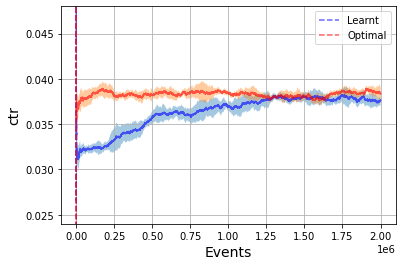

In [9]:
plot_ctr(avg_ctr,avg_o_ctr,maxP,minP)
print('Optimal total reward: '+str(-1*np.mean(avg_o_cost_sum))+' Algorithm total reward: '+str(-1*np.mean(avg_cost_sum)))